In [1]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier/notebooks'

In [2]:
import os
os.chdir("../")

In [3]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier'

In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix


In [5]:
RUN_ID = "run_20260203_161558"

FEATURE_ROOT = Path("/scratch/users/arunps/speaker-type-classifier/artifacts_feature_store/v1")

EGEMAPS_DIR = FEATURE_ROOT / "egemaps" / RUN_ID
W2V_DIR     = FEATURE_ROOT / "wav2vec2" / RUN_ID

print("EGEMAPS_DIR:", EGEMAPS_DIR, "| exists:", EGEMAPS_DIR.exists())
print("W2V_DIR:    ", W2V_DIR, "| exists:", W2V_DIR.exists())


EGEMAPS_DIR: /scratch/users/arunps/speaker-type-classifier/artifacts_feature_store/v1/egemaps/run_20260203_161558 | exists: True
W2V_DIR:     /scratch/users/arunps/speaker-type-classifier/artifacts_feature_store/v1/wav2vec2/run_20260203_161558 | exists: True


In [6]:
def load_feature_pack(feature_dir: Path):
    Xtr = np.load(feature_dir / "train_X.npy")
    ytr = np.load(feature_dir / "train_y.npy")
    Xva = np.load(feature_dir / "val_X.npy")
    yva = np.load(feature_dir / "val_y.npy")
    
    train_index = pd.read_csv(feature_dir / "train_index.csv")
    val_index   = pd.read_csv(feature_dir / "val_index.csv")
    
    return Xtr, ytr, Xva, yva, train_index, val_index

Xtr_e, ytr_e, Xva_e, yva_e, idx_tr_e, idx_va_e = load_feature_pack(EGEMAPS_DIR)
Xtr_w, ytr_w, Xva_w, yva_w, idx_tr_w, idx_va_w = load_feature_pack(W2V_DIR)

print("eGeMAPS:", Xtr_e.shape, ytr_e.shape, "|", Xva_e.shape, yva_e.shape)
print("wav2vec2:", Xtr_w.shape, ytr_w.shape, "|", Xva_w.shape, yva_w.shape)


eGeMAPS: (54068, 88) (54068,) | (13517, 88) (13517,)
wav2vec2: (54068, 768) (54068,) | (13517, 768) (13517,)


In [7]:
assert len(idx_tr_e) == Xtr_e.shape[0] == ytr_e.shape[0]
assert len(idx_va_e) == Xva_e.shape[0] == yva_e.shape[0]
assert len(idx_tr_w) == Xtr_w.shape[0] == ytr_w.shape[0]
assert len(idx_va_w) == Xva_w.shape[0] == yva_w.shape[0]

# Also labels should align between egemaps and wav2vec2 (same split)
assert np.array_equal(ytr_e, ytr_w), "Train labels differ between feature sets!"
assert np.array_equal(yva_e, yva_w), "Val labels differ between feature sets!"

print("Shapes and alignment checks passed.")


Shapes and alignment checks passed.


In [8]:
ID2LABEL = {0: "adult_male", 1: "adult_female", 2: "child", 3: "background"}

def label_counts(y):
    s = pd.Series(y).value_counts().sort_index()
    s.index = [ID2LABEL.get(i, str(i)) for i in s.index]
    return s

print("Train label counts:\n", label_counts(ytr_e))
print("\nVal label counts:\n", label_counts(yva_e))


Train label counts:
 adult_male      16000
adult_female    16000
child           10707
background      11361
Name: count, dtype: int64

Val label counts:
 adult_male      4000
adult_female    4000
child           2677
background      2840
Name: count, dtype: int64


In [9]:
display(idx_tr_e.head(10))
display(idx_va_e.head(10))


,audio_path,label
0,/scratch/users/arunps/speaker-type-classifier/...,child
1,/scratch/users/arunps/speaker-type-classifier/...,child
2,/scratch/users/arunps/speaker-type-classifier/...,child
3,/scratch/users/arunps/speaker-type-classifier/...,child
4,/scratch/users/arunps/speaker-type-classifier/...,child
5,/scratch/users/arunps/speaker-type-classifier/...,child
6,/scratch/users/arunps/speaker-type-classifier/...,child
7,/scratch/users/arunps/speaker-type-classifier/...,child
8,/scratch/users/arunps/speaker-type-classifier/...,child
9,/scratch/users/arunps/speaker-type-classifier/...,child


,audio_path,label
0,/scratch/users/arunps/speaker-type-classifier/...,child
1,/scratch/users/arunps/speaker-type-classifier/...,child
2,/scratch/users/arunps/speaker-type-classifier/...,child
3,/scratch/users/arunps/speaker-type-classifier/...,child
4,/scratch/users/arunps/speaker-type-classifier/...,child
5,/scratch/users/arunps/speaker-type-classifier/...,child
6,/scratch/users/arunps/speaker-type-classifier/...,child
7,/scratch/users/arunps/speaker-type-classifier/...,child
8,/scratch/users/arunps/speaker-type-classifier/...,child
9,/scratch/users/arunps/speaker-type-classifier/...,child


In [10]:
def sanity_stats(X, name):
    print(f"\n=== {name} ===")
    print("shape:", X.shape, "dtype:", X.dtype)
    print("nan count:", np.isnan(X).sum())
    print("inf count:", np.isinf(X).sum())
    print("min:", float(np.min(X)), "max:", float(np.max(X)))
    print("mean:", float(np.mean(X)), "std:", float(np.std(X)))

sanity_stats(Xtr_e, "eGeMAPS train")
sanity_stats(Xva_e, "eGeMAPS val")
sanity_stats(Xtr_w, "wav2vec2 train")
sanity_stats(Xva_w, "wav2vec2 val")



=== eGeMAPS train ===
shape: (54068, 88) dtype: float32
nan count: 0
inf count: 0
min: -343871.3125 max: 299334.0
mean: 99.50006866455078 std: 461.9286804199219

=== eGeMAPS val ===
shape: (13517, 88) dtype: float32
nan count: 0
inf count: 0
min: -239275.9375 max: 69770.21875
mean: 98.8870620727539 std: 484.27923583984375

=== wav2vec2 train ===
shape: (54068, 768) dtype: float32
nan count: 0
inf count: 0
min: -4.316626071929932 max: 4.990303039550781
mean: -0.0009003966697491705 std: 0.24953694641590118

=== wav2vec2 val ===
shape: (13517, 768) dtype: float32
nan count: 0
inf count: 0
min: -3.7021484375 max: 3.429652214050293
mean: -0.0008806641562841833 std: 0.25100862979888916


In [11]:
def feature_summary(X, top_k=10):
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    const_dims = np.where(sd == 0)[0]
    print("Total dims:", X.shape[1])
    print("Constant dims:", len(const_dims))
    if len(const_dims) > 0:
        print("First constant dims:", const_dims[:20])

    # show top varying dims
    top = np.argsort(sd)[::-1][:top_k]
    df = pd.DataFrame({"dim": top, "mean": mu[top], "std": sd[top]})
    return df

display(feature_summary(Xtr_e, top_k=15))
display(feature_summary(Xtr_w, top_k=15))


Total dims: 88
Constant dims: 0


,dim,mean,std
0,65,-6.638889,1482.095581
1,27,6.833882,1291.568115
2,71,5.022406,753.089478
3,52,2701.625488,480.433594
4,73,2.438149,324.781494
5,46,1699.288940,314.410461
6,42,1287.481689,251.082016
7,37,2.436509,212.647659
8,48,1044.097778,207.358673
9,7,140.682190,198.155426


Total dims: 768
Constant dims: 0


,dim,mean,std
0,544,-0.188147,1.082398
1,153,0.237737,0.914767
2,581,-0.521282,0.911977
3,365,-0.610218,0.723549
4,352,0.309511,0.662622
5,619,-0.177536,0.653613
6,375,0.179347,0.571855
7,249,-0.207468,0.566816
8,96,-0.076763,0.556108
9,395,0.755520,0.545087


In [12]:
def mean_drift(Xtr, Xva):
    tr_mu = Xtr.mean(axis=0)
    va_mu = Xva.mean(axis=0)
    drift = np.mean(np.abs(tr_mu - va_mu))
    return float(drift)

print("Mean drift eGeMAPS:", mean_drift(Xtr_e, Xva_e))
print("Mean drift wav2vec2:", mean_drift(Xtr_w, Xva_w))


Mean drift eGeMAPS: 0.9645313024520874
Mean drift wav2vec2: 0.003778978483751416


In [13]:
from sklearn.decomposition import PCA

def pca_preview(X, y, title, n=5000, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=min(n, len(X)), replace=False)
    Xs = X[idx]
    ys = y[idx]
    
    pca = PCA(n_components=2, random_state=seed)
    Z = pca.fit_transform(Xs)
    df = pd.DataFrame({"pc1": Z[:,0], "pc2": Z[:,1], "label": [ID2LABEL[i] for i in ys]})
    return df, pca.explained_variance_ratio_

df_e, evr_e = pca_preview(Xtr_e, ytr_e, "eGeMAPS")
df_w, evr_w = pca_preview(Xtr_w, ytr_w, "wav2vec2")

print("eGeMAPS PCA EVR:", evr_e)
print("wav2vec2 PCA EVR:", evr_w)

display(df_e.head())
display(df_w.head())


eGeMAPS PCA EVR: [0.66936034 0.16743723]
wav2vec2 PCA EVR: [0.3483906  0.24887024]


,pc1,pc2,label
0,-26.824478,-63.607178,adult_male
1,-62.679832,-113.841797,adult_male
2,-17.059669,219.886230,adult_female
3,-17.148682,150.819824,adult_male
4,-18.988087,257.898926,child


,pc1,pc2,label
0,0.999456,3.754389,adult_male
1,0.953537,4.722779,adult_male
2,4.495241,-1.655153,adult_female
3,-0.056988,5.348176,adult_male
4,-3.506781,-0.310230,child


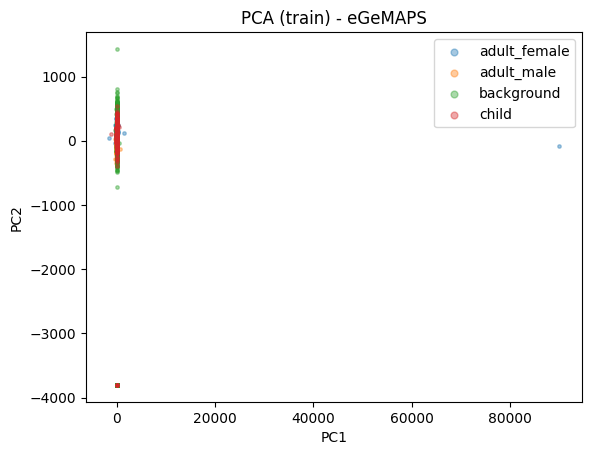

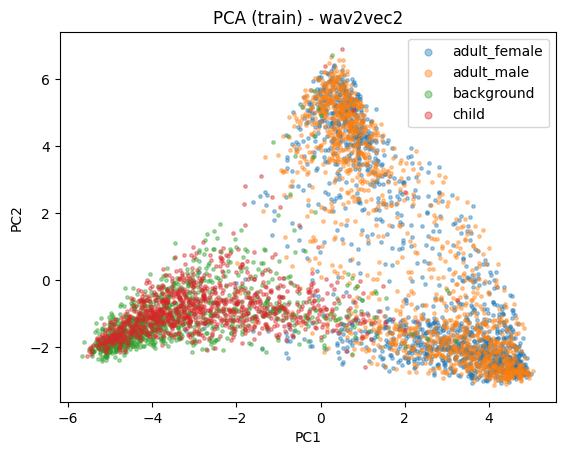

In [14]:
import matplotlib.pyplot as plt

def plot_scatter(df, title):
    plt.figure()
    for lab, g in df.groupby("label"):
        plt.scatter(g["pc1"], g["pc2"], s=6, alpha=0.4, label=lab)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(markerscale=2)
    plt.show()

plot_scatter(df_e, "PCA (train) - eGeMAPS")
plot_scatter(df_w, "PCA (train) - wav2vec2")


In [15]:
def count_all_zero_rows(X):
    return int(np.sum(np.all(X == 0, axis=1)))

print("Zero rows eGeMAPS train:", count_all_zero_rows(Xtr_e))
print("Zero rows eGeMAPS val:  ", count_all_zero_rows(Xva_e))
print("Zero rows wav2vec2 train:", count_all_zero_rows(Xtr_w))
print("Zero rows wav2vec2 val:  ", count_all_zero_rows(Xva_w))


Zero rows eGeMAPS train: 0
Zero rows eGeMAPS val:   0
Zero rows wav2vec2 train: 0
Zero rows wav2vec2 val:   0
